# Single-image food volume estimation
Using a  monocular depth estimation network and a segmentation network, we will estimate the volume of the food displayed in the input image.

In [7]:
import sys
import os
# Add parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import json
from tensorflow.keras.models import Model, model_from_json # Updated from keras.models
from food_volume_estimation.volume_estimator import VolumeEstimator
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Paths to model architecture/weights (Updated paths)
depth_model_architecture = '../models/depth_architecture.json'
depth_model_weights = '../models/depth_weights.h5'
segmentation_model_weights = '../models/FoodSeg.onnx'

In [8]:
# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

[*] VolumeEstimator not initialized.
[*] Loaded depth estimation model.
[*] Loading segmentation model weights ../models/FoodSeg.onnx


[*] Creating intrinsics matrix from given FOV: 70
1/1 [==============================] - 1s 1s/step
[*] Ellipse parameters: (104.47132110595703, 71.95915222167969, 98.0, 43.55555555555555, 0.02632619542114334)
[*] Found 9 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.2527527603547344, 0.10040702388870583, -0.2653722613461998, -0.9589035365780112]
[*] Estimated volume: 0.5502429327539978 L


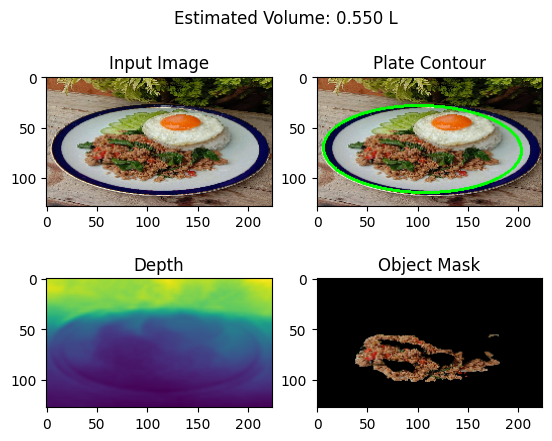

[*] Estimated plane parameters (w0,w1,w2,w3): [0.232975628420345, 0.2756844269424103, -0.40083552916188103, -0.8736870007634023]
[*] Estimated volume: 0.40301554748169577 L


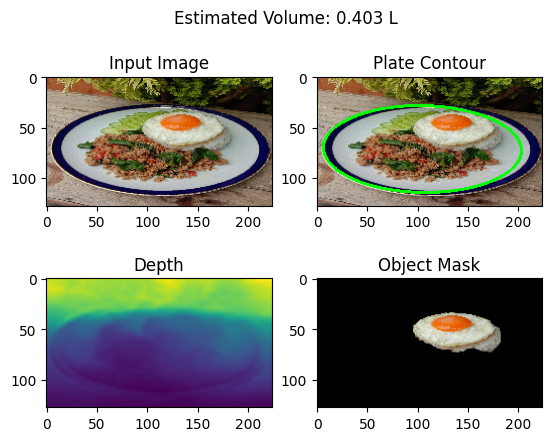

[*] Estimated plane parameters (w0,w1,w2,w3): [0.19318811404410918, 0.1631325729038801, -0.6458304040581286, -0.7458490818200924]
[*] Estimated volume: 0.10927000994257063 L


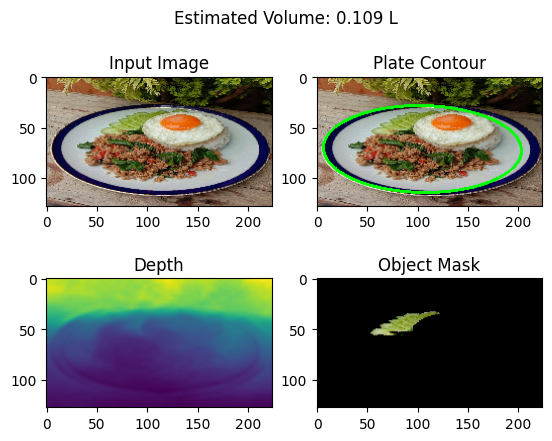

[*] Estimated plane parameters (w0,w1,w2,w3): [0.23767556471974938, 0.005105818649974616, -0.3133479726876032, -0.949624651443128]
[*] Estimated volume: 0.005069637541986975 L


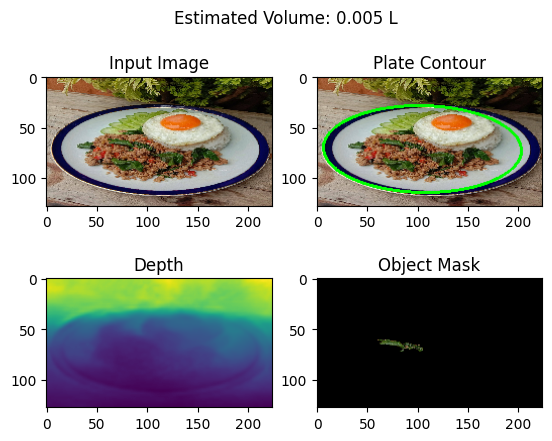

[*] Estimated plane parameters (w0,w1,w2,w3): [0.24956401485748841, -0.17049950447275514, -0.18528216963862595, -0.9677811925164429]
[*] Estimated volume: 0.0013252844199384678 L


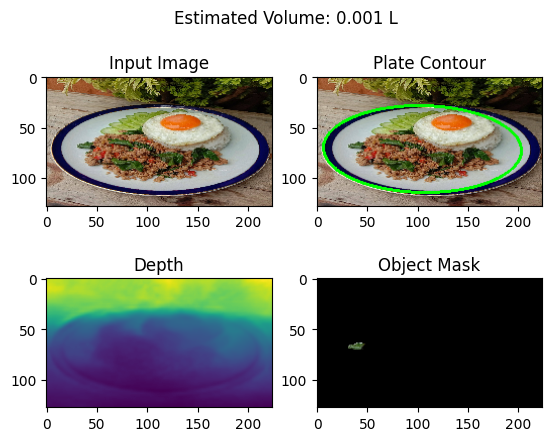

[*] Estimated plane parameters (w0,w1,w2,w3): [0.43396704636307204, 0.3893300804089791, -0.0818451526335913, -0.9174548814405655]
[*] Estimated volume: 0.0009621316126950632 L


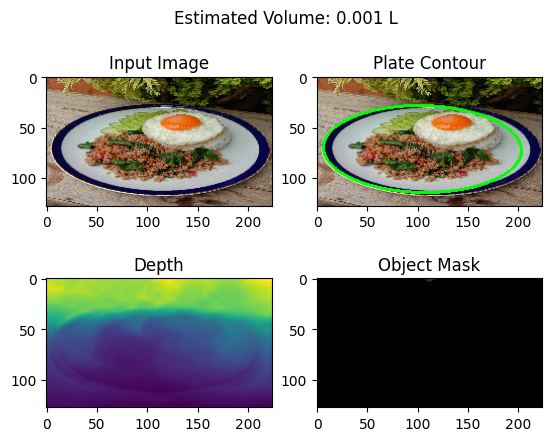

[*] Estimated plane parameters (w0,w1,w2,w3): [0.3947360900706102, 0.01624818142635978, -0.23214875742810093, -0.9725445753408555]
[*] Estimated volume: 1.6706438155967747 L


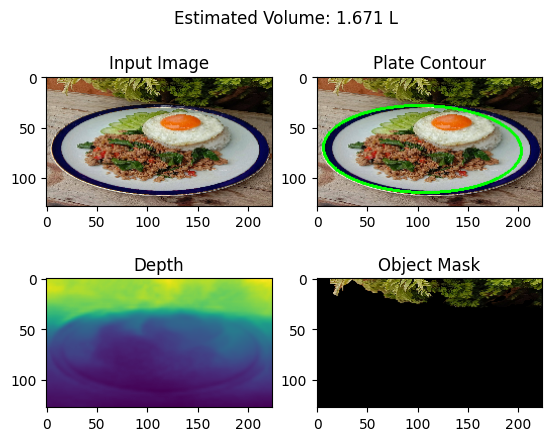

[*] Estimated plane parameters (w0,w1,w2,w3): [0.23485766279284087, -0.003933120685197426, -0.0361301205709908, -0.9993393542481959]
[*] Estimated volume: 0.0039987152764256765 L


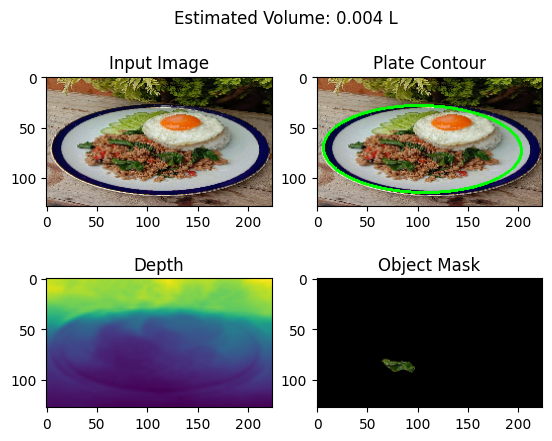

[*] Estimated plane parameters (w0,w1,w2,w3): [0.11535755078046551, -0.09301075129763897, -0.8044190486335788, -0.5867358812434231]
[*] Estimated volume: 0.0025106971530845634 L


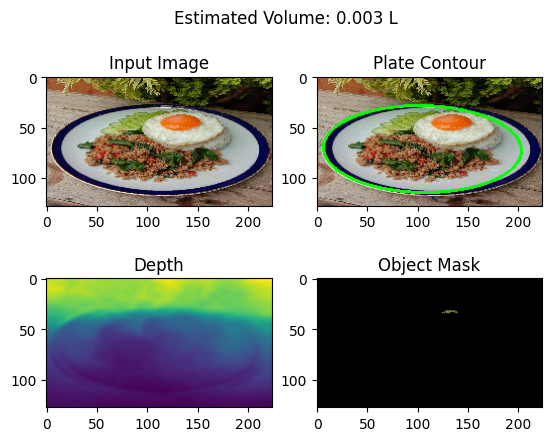

<Figure size 650x530 with 0 Axes>

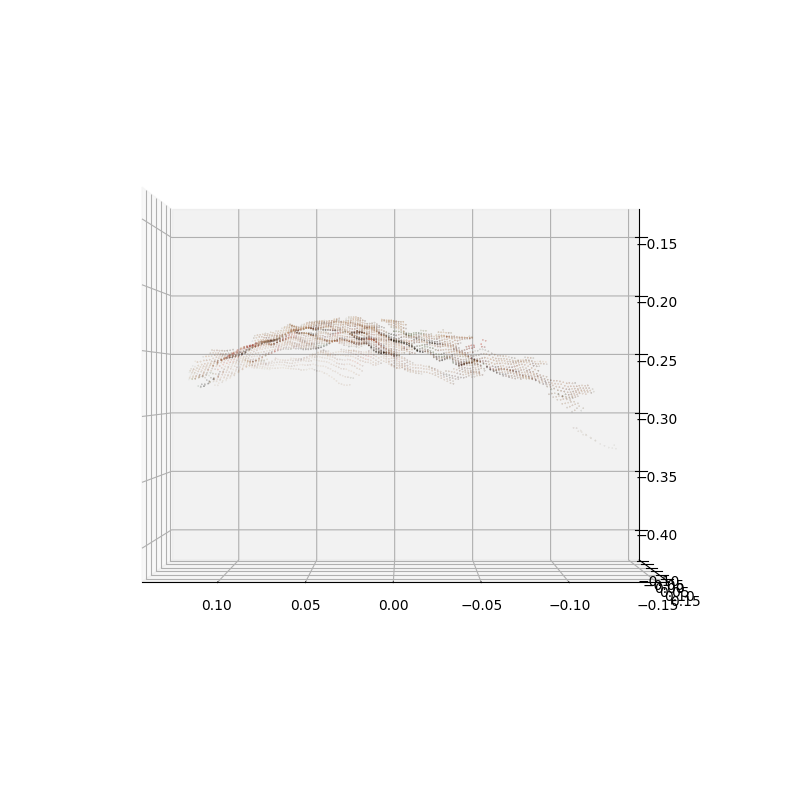

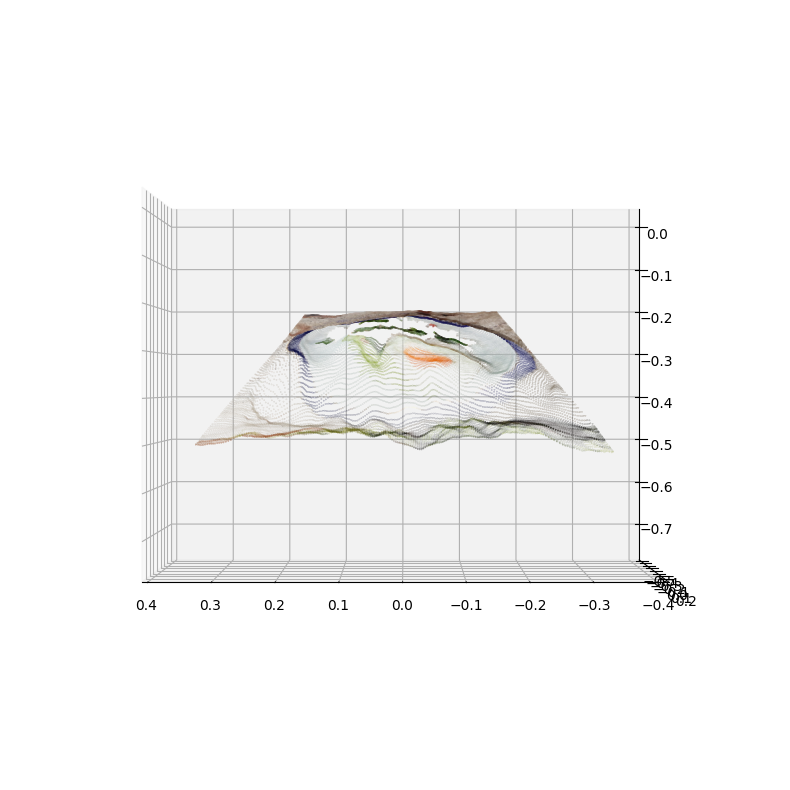

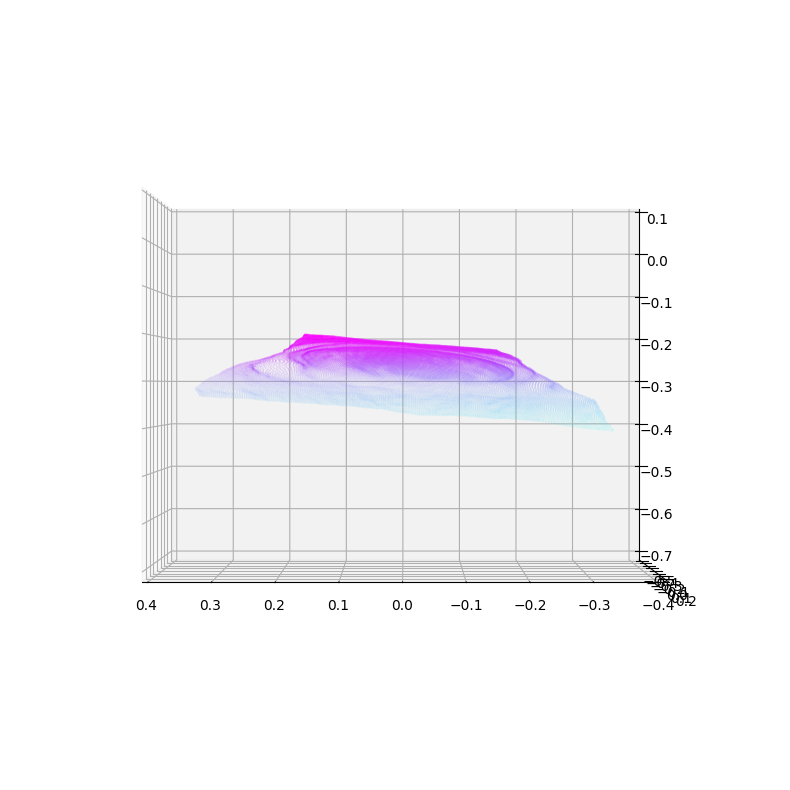

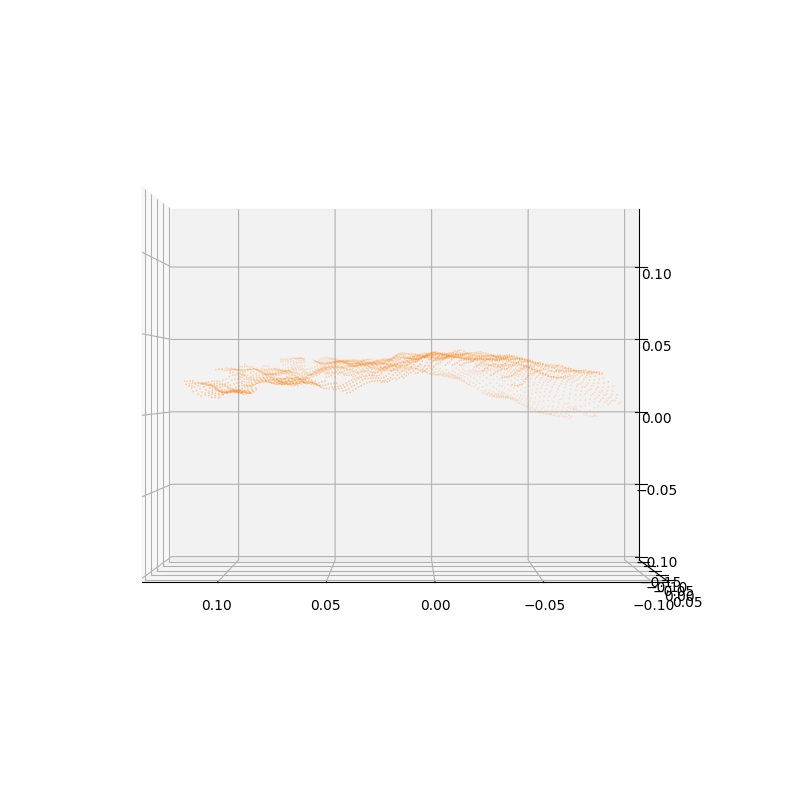

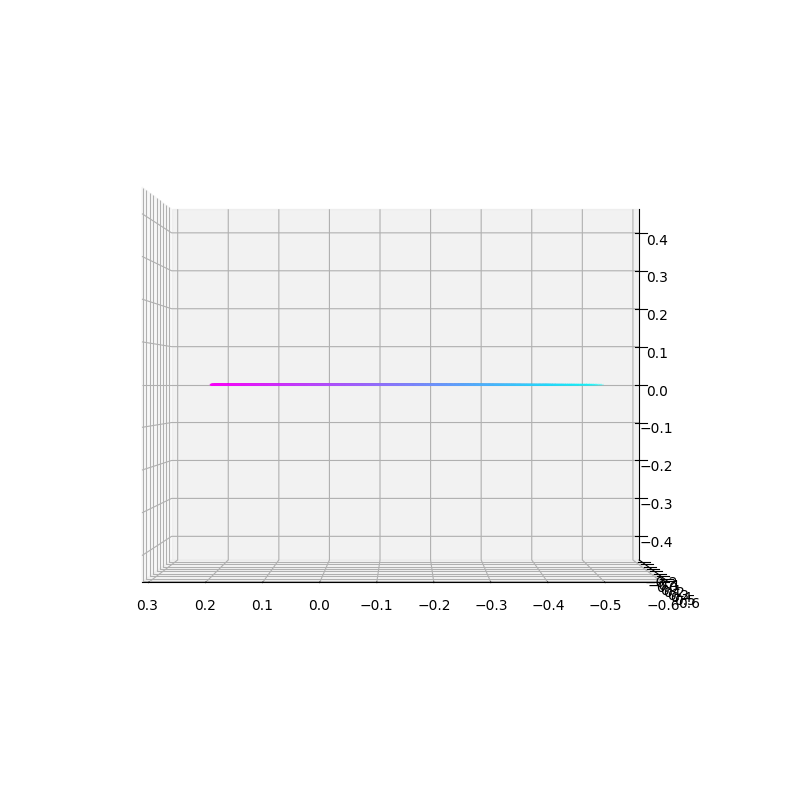

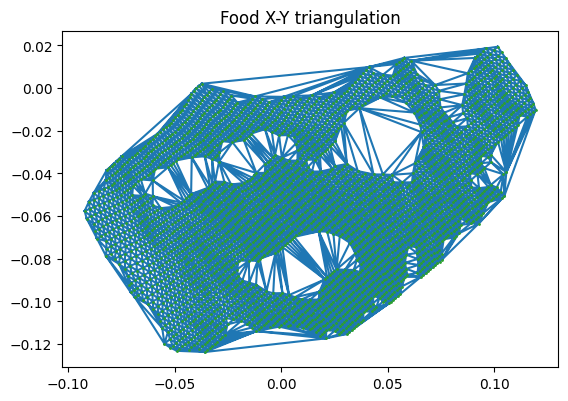

<Figure size 650x530 with 0 Axes>

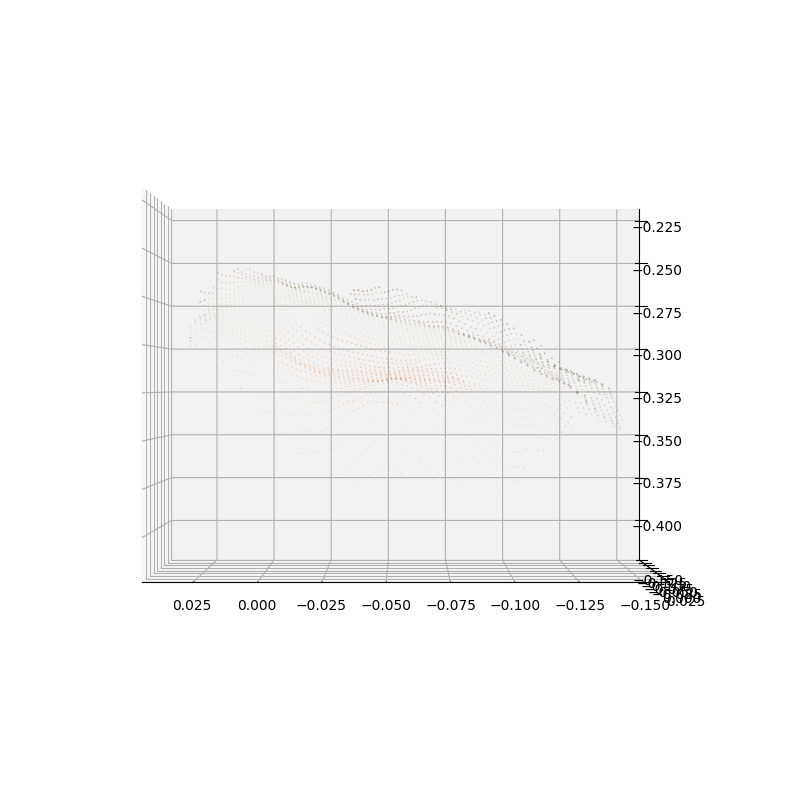

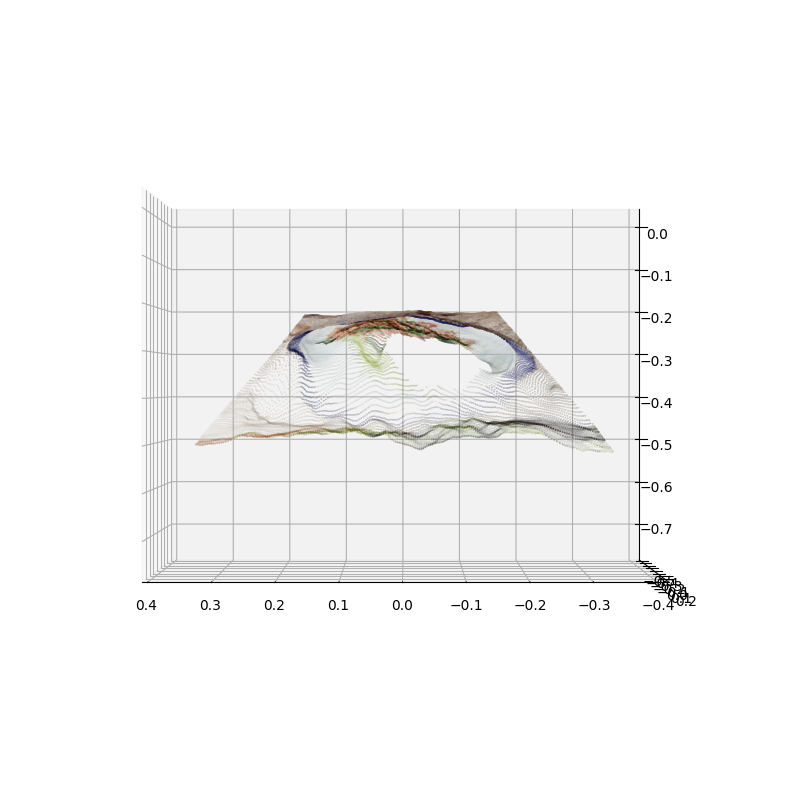

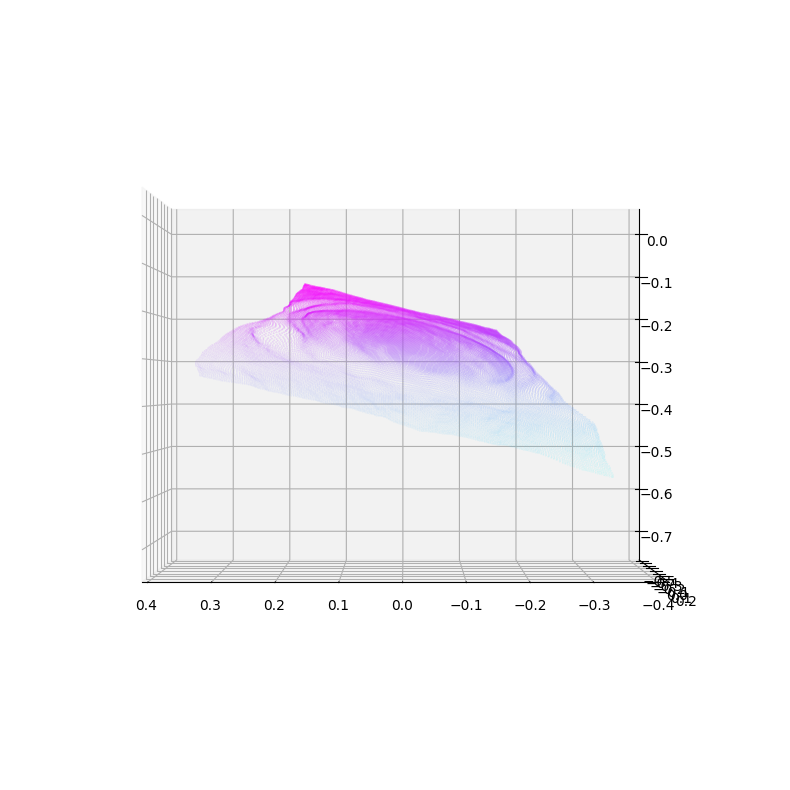

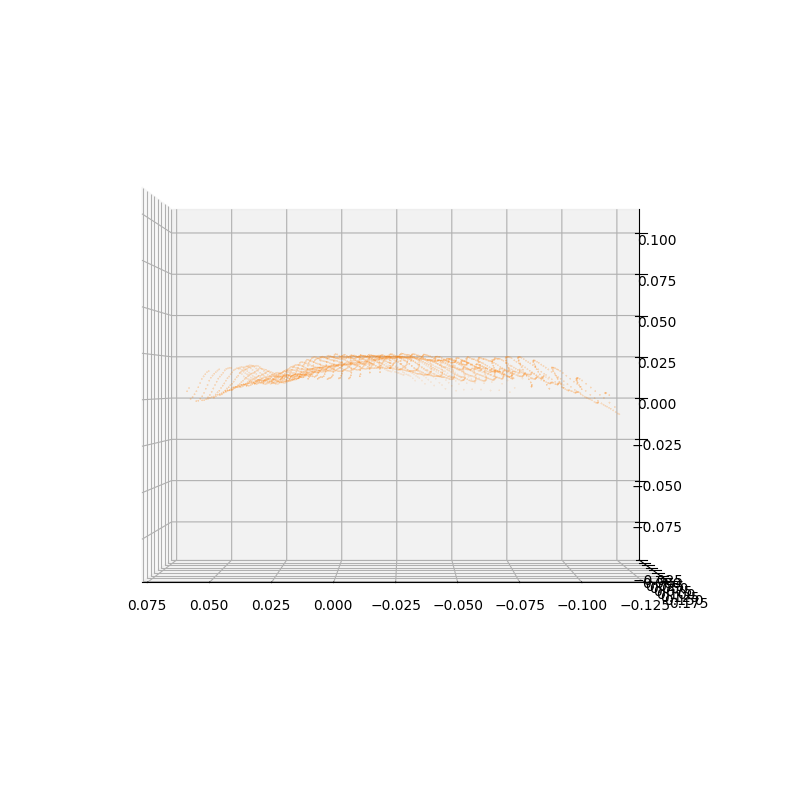

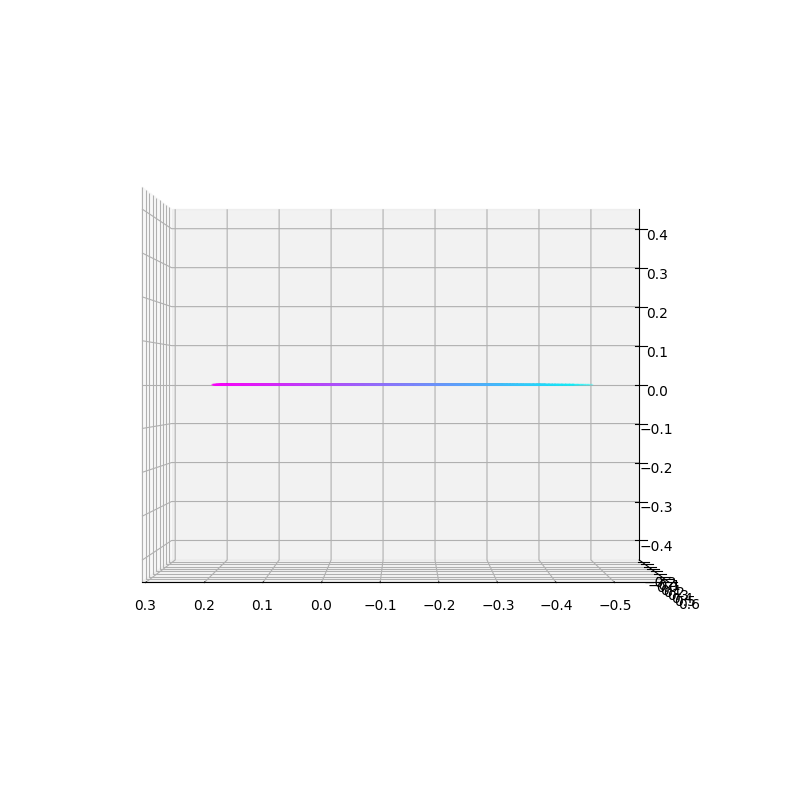

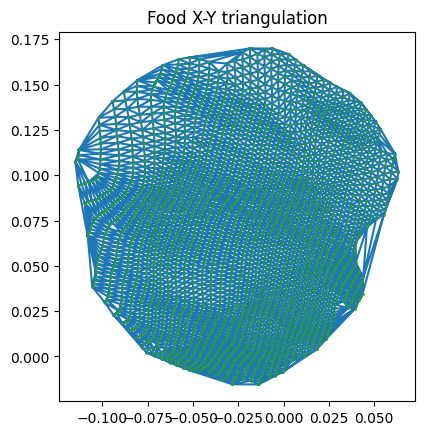

<Figure size 650x530 with 0 Axes>

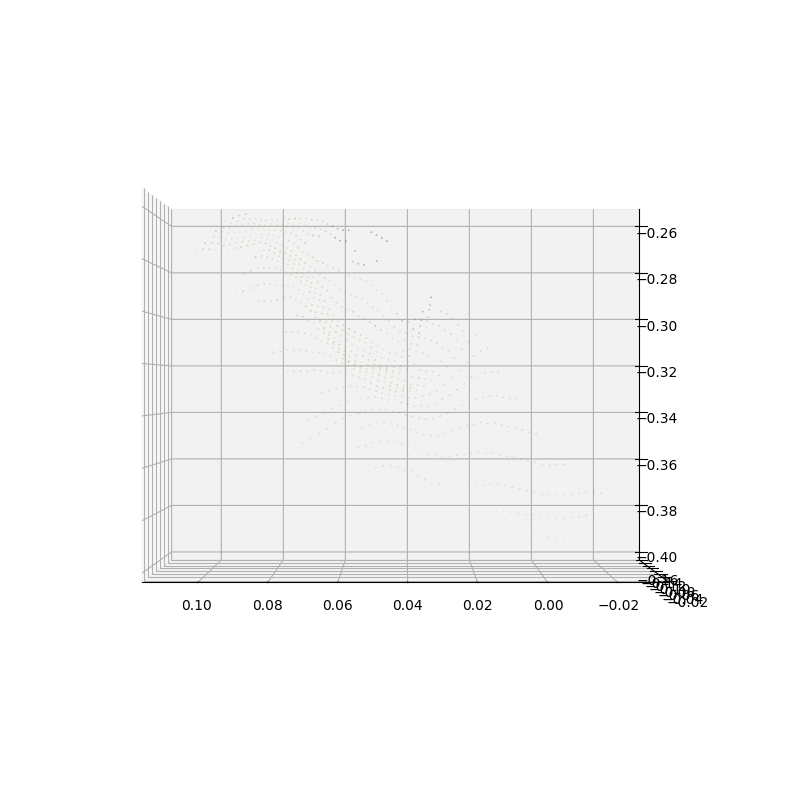

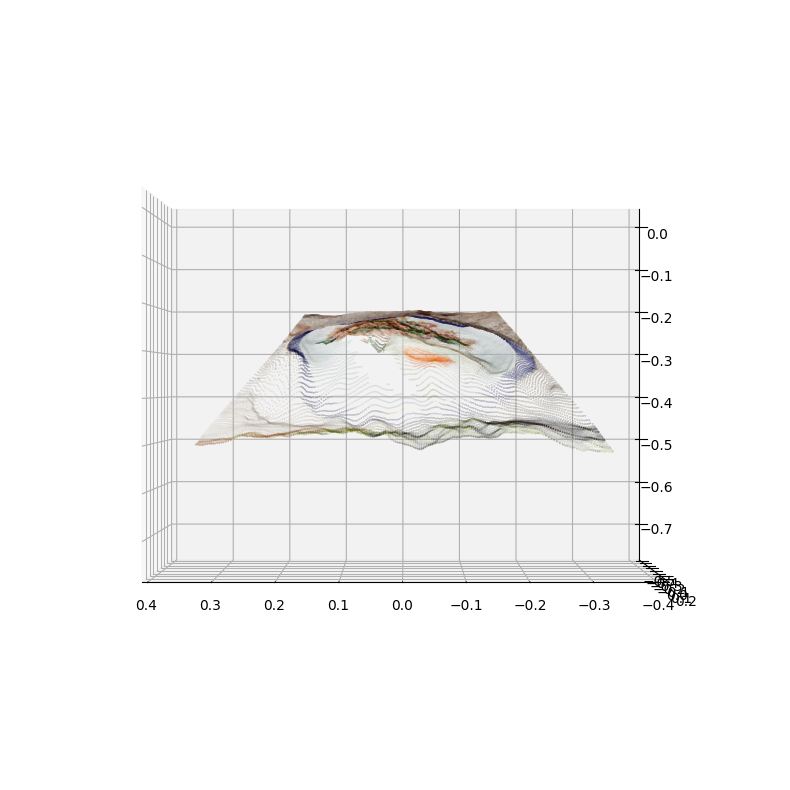

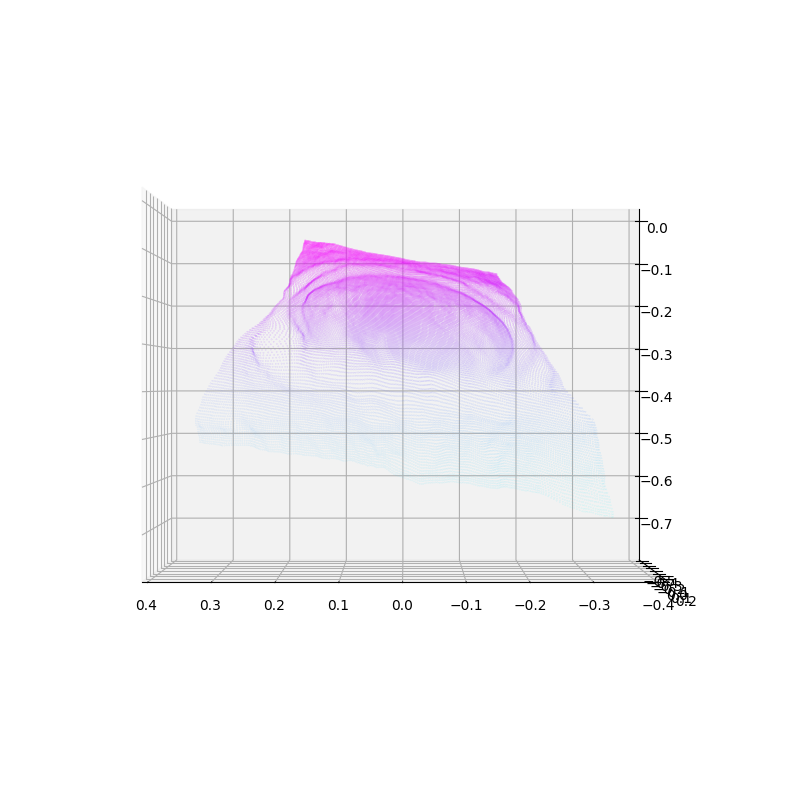

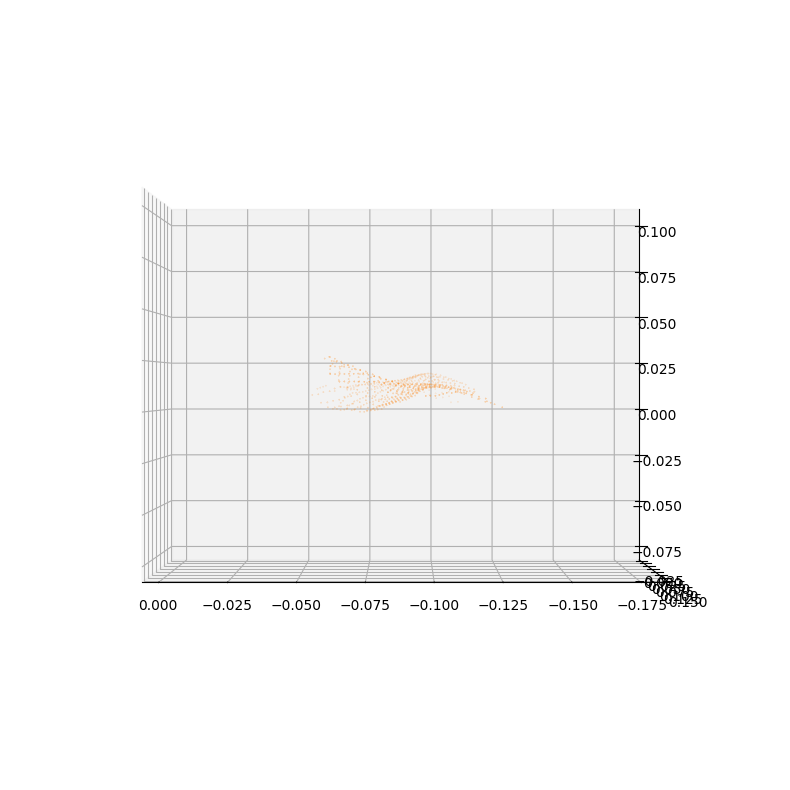

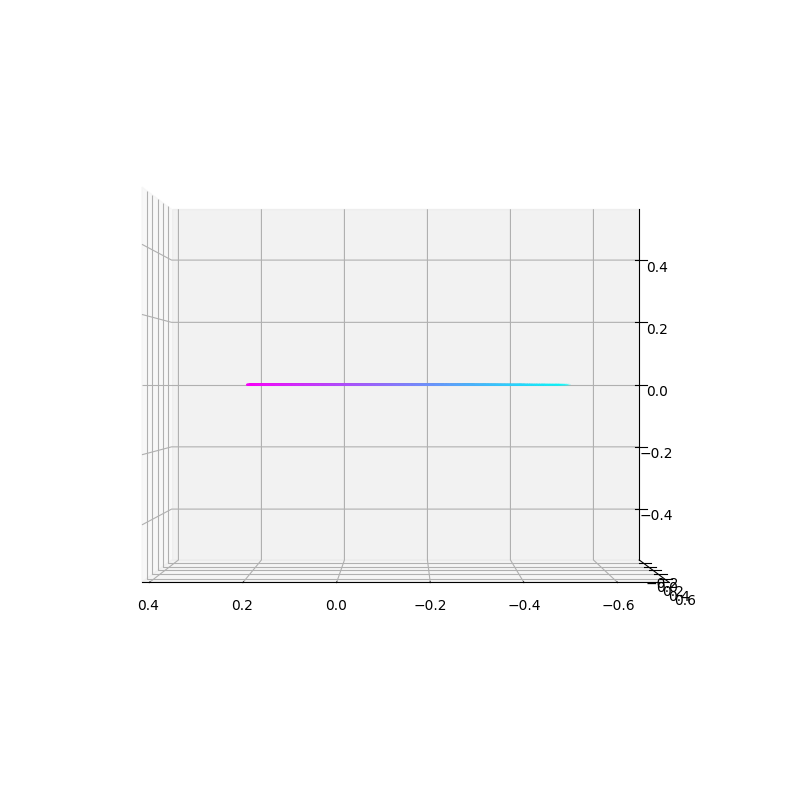

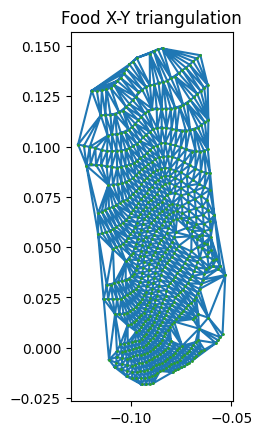

<Figure size 650x530 with 0 Axes>

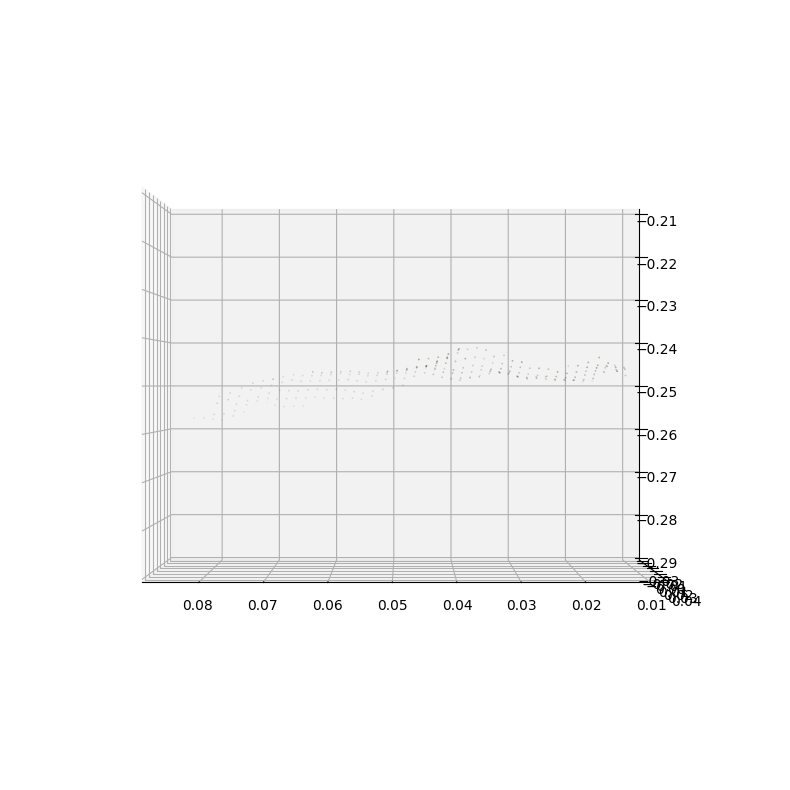

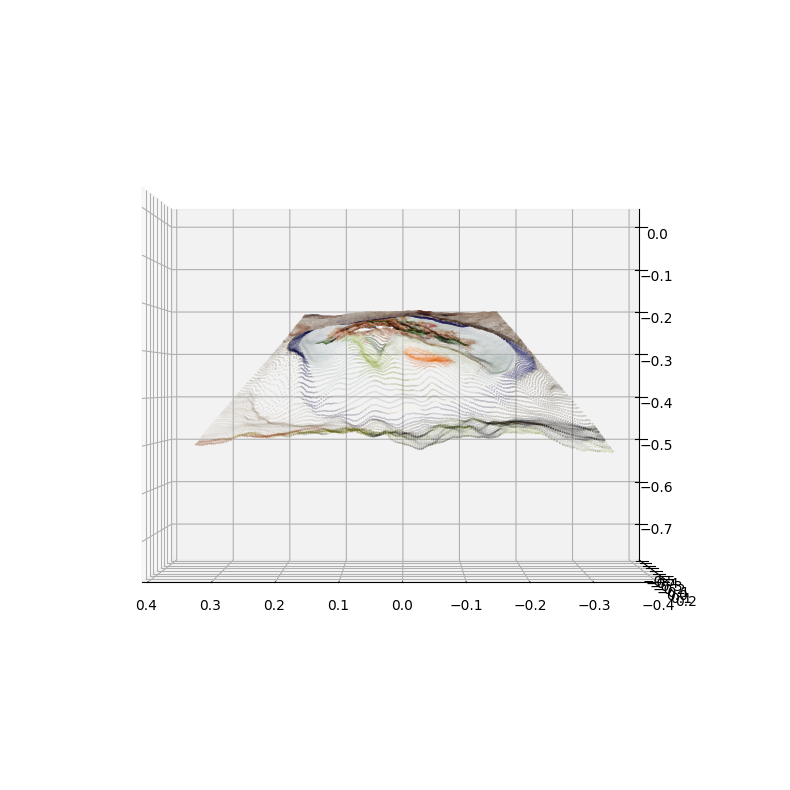

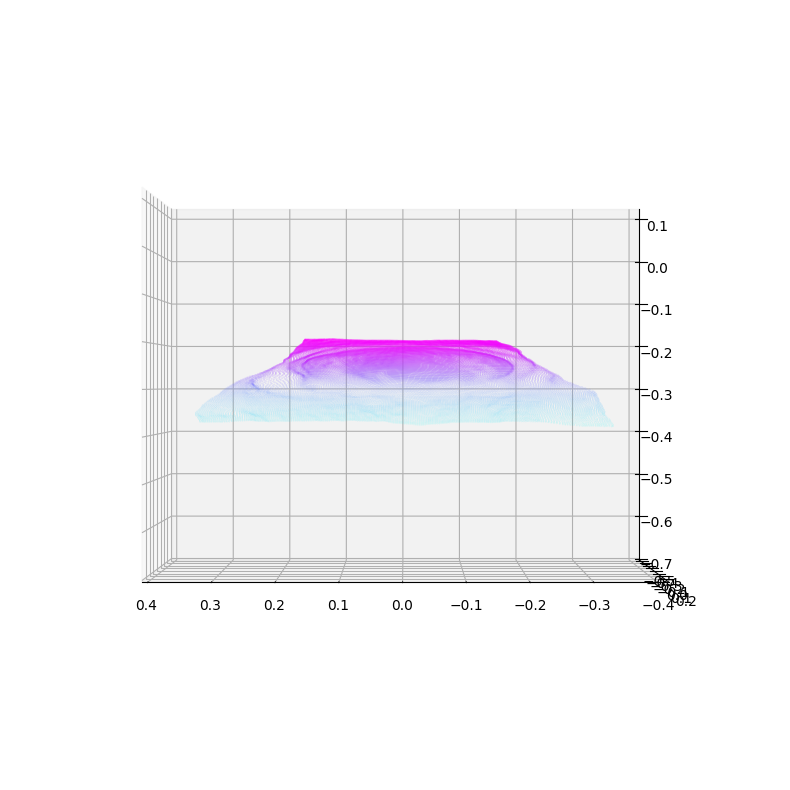

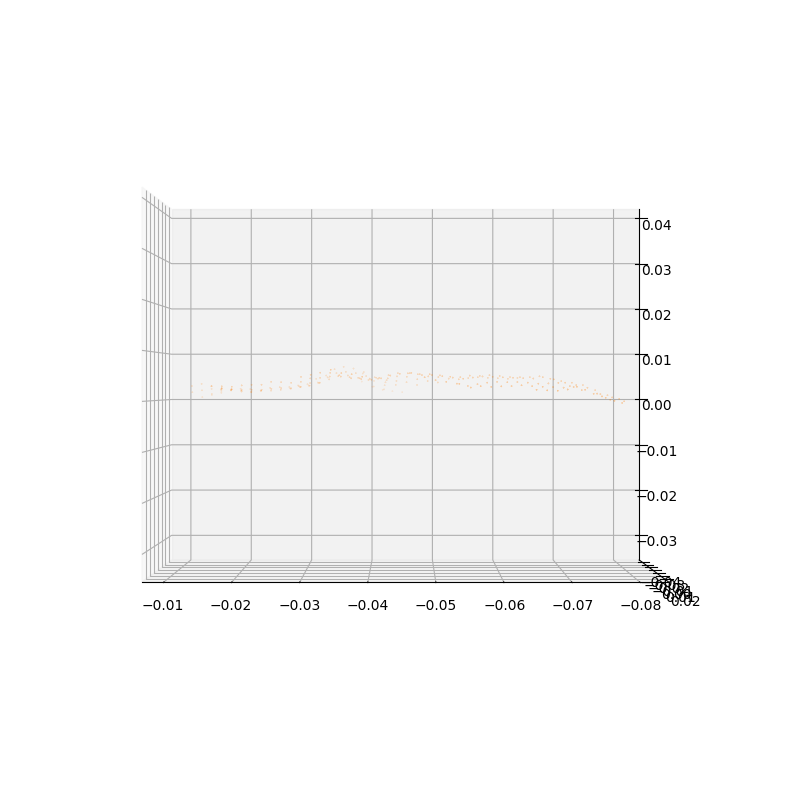

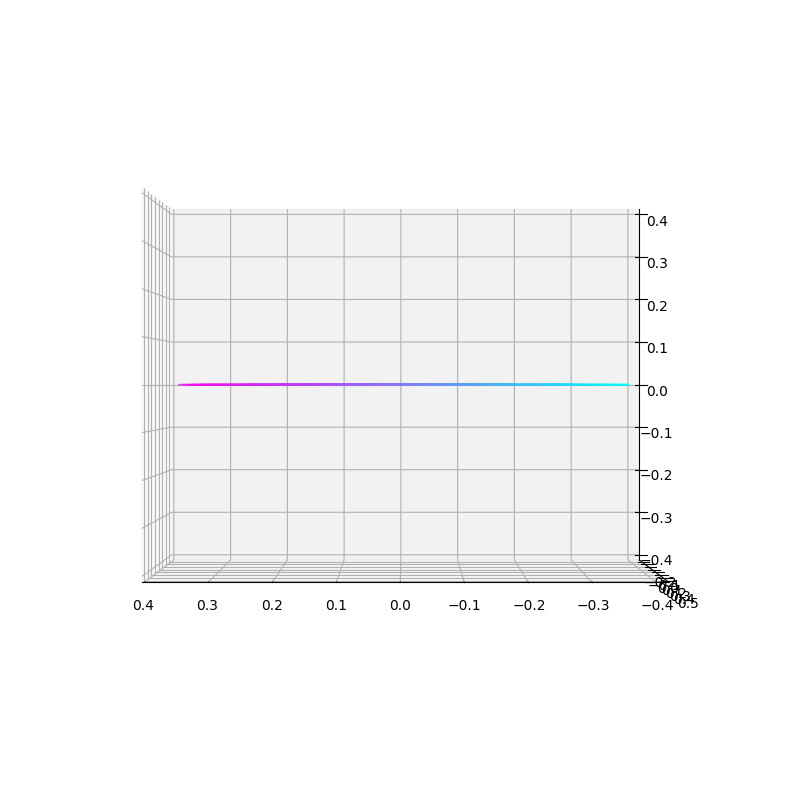

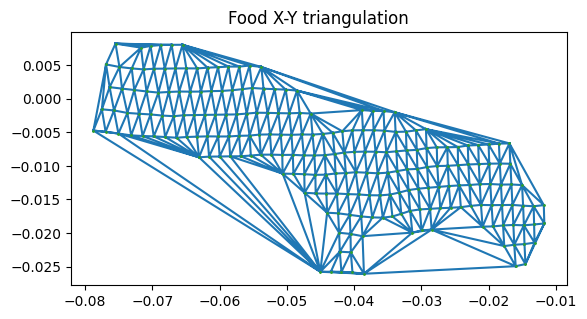

<Figure size 650x530 with 0 Axes>

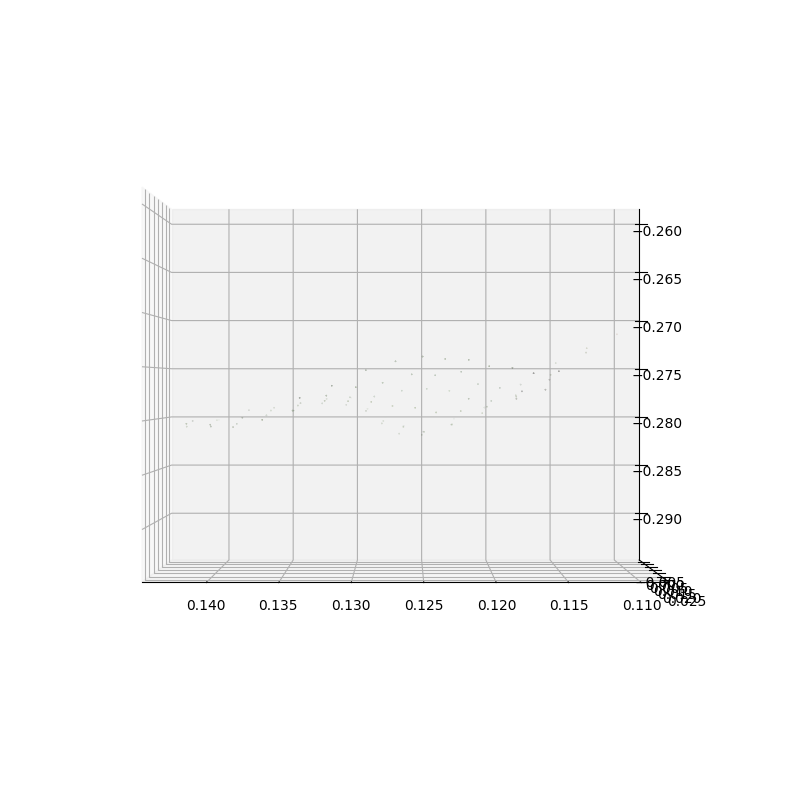

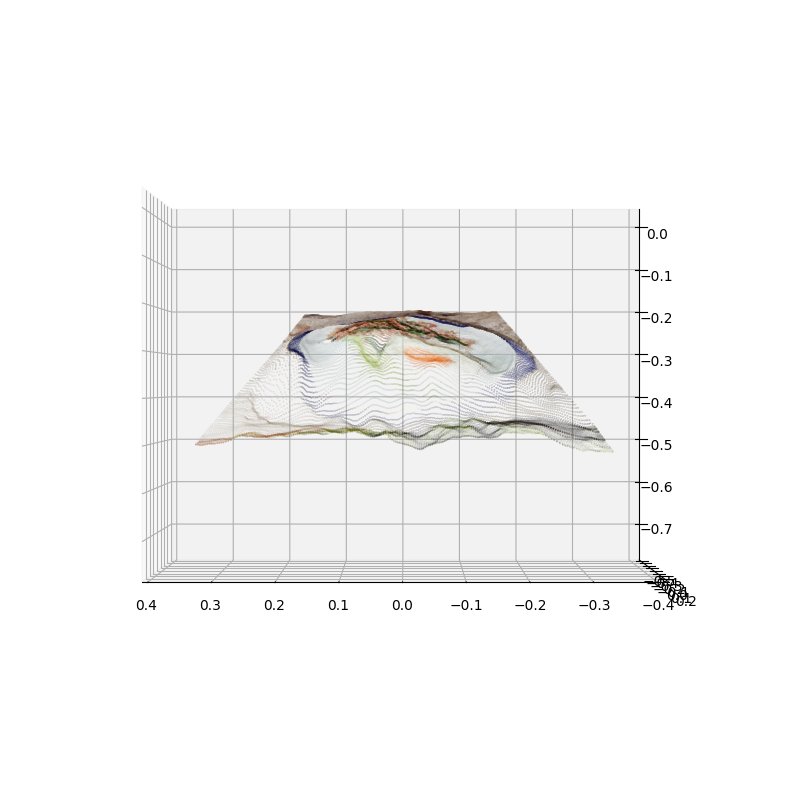

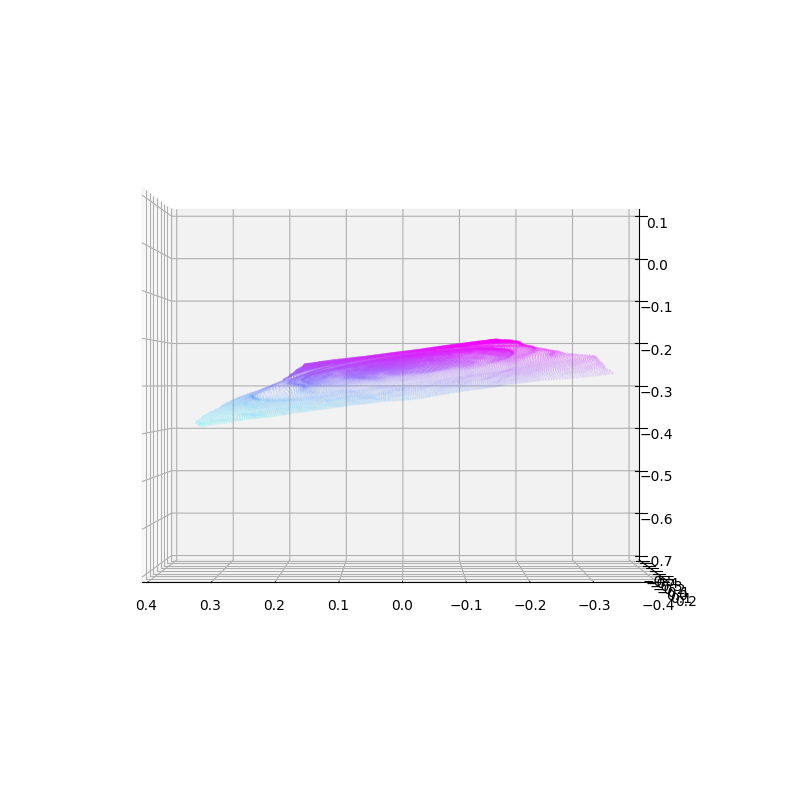

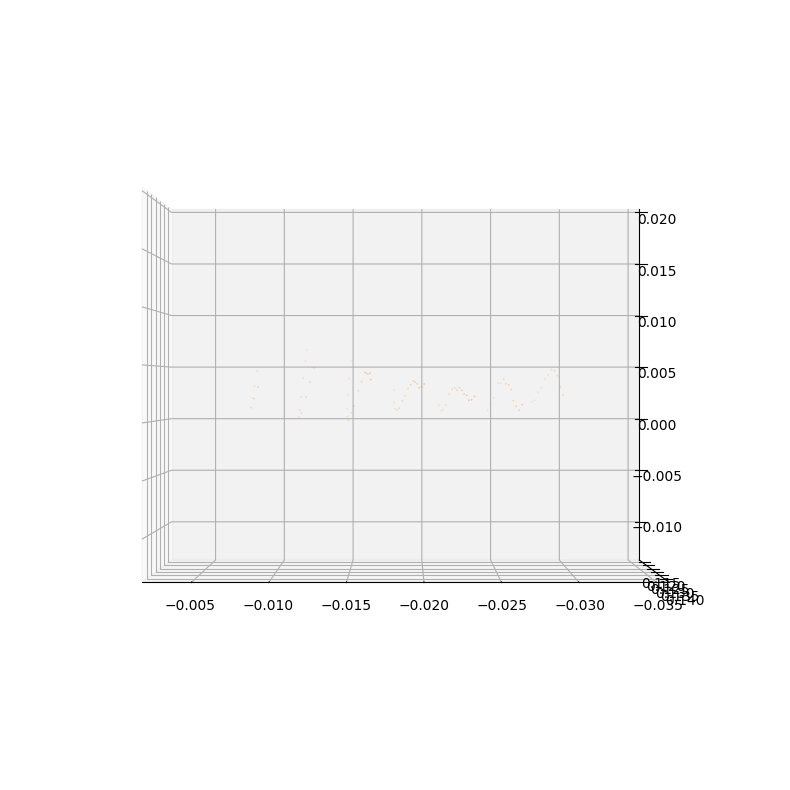

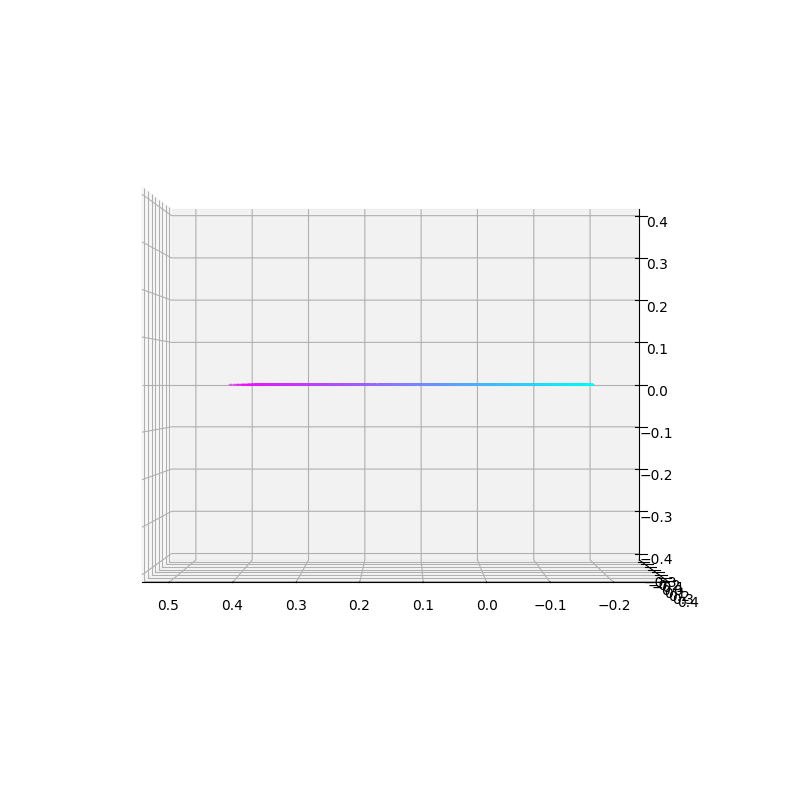

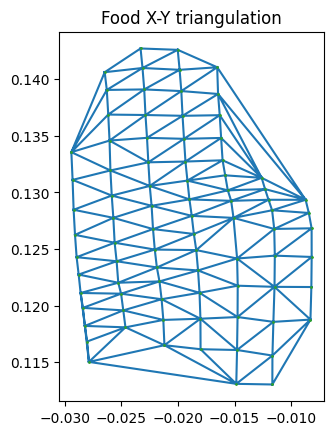

<Figure size 650x530 with 0 Axes>

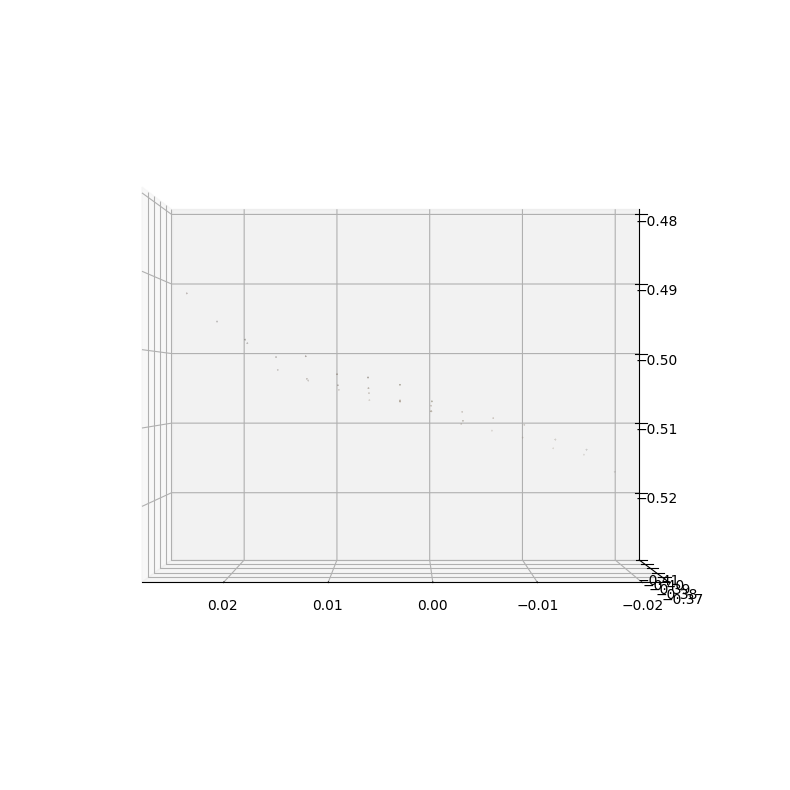

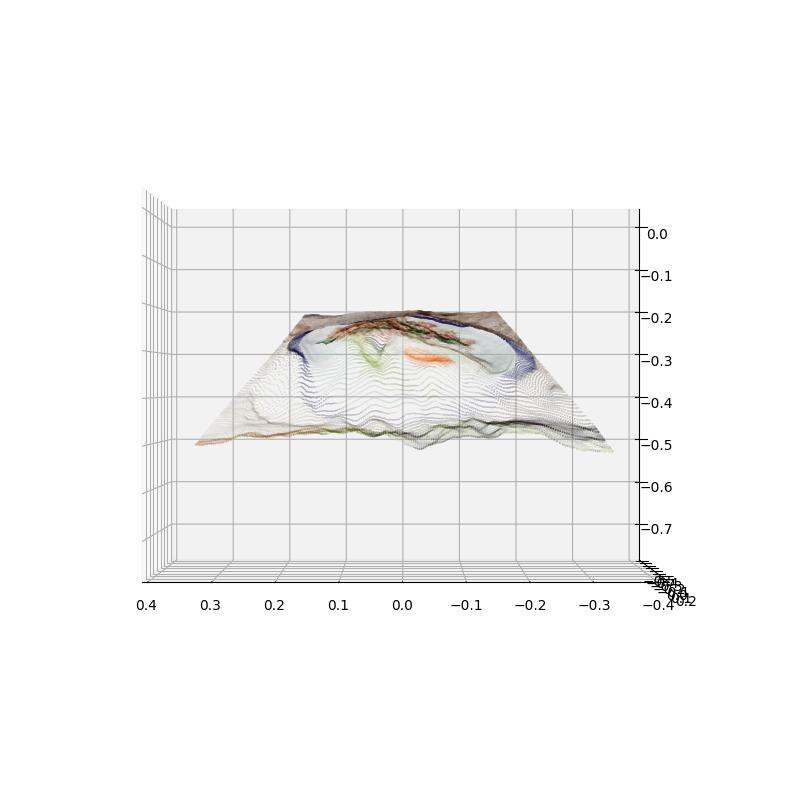

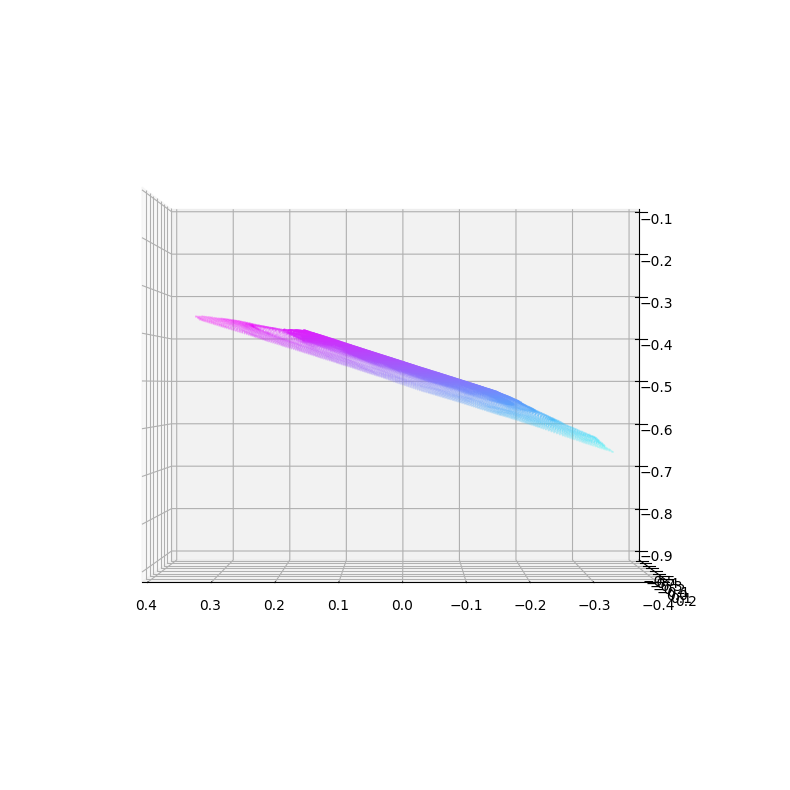

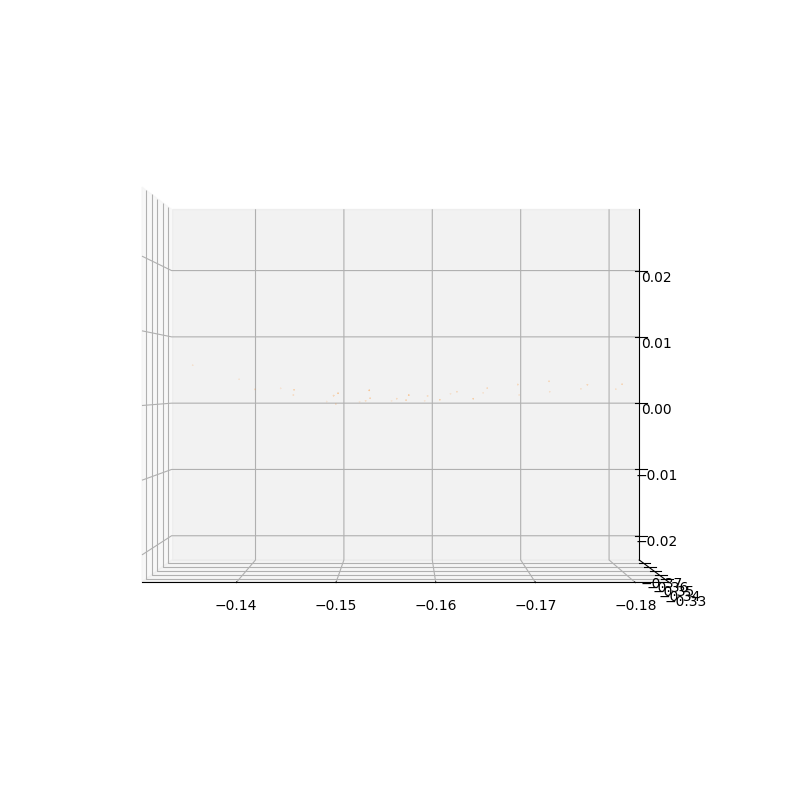

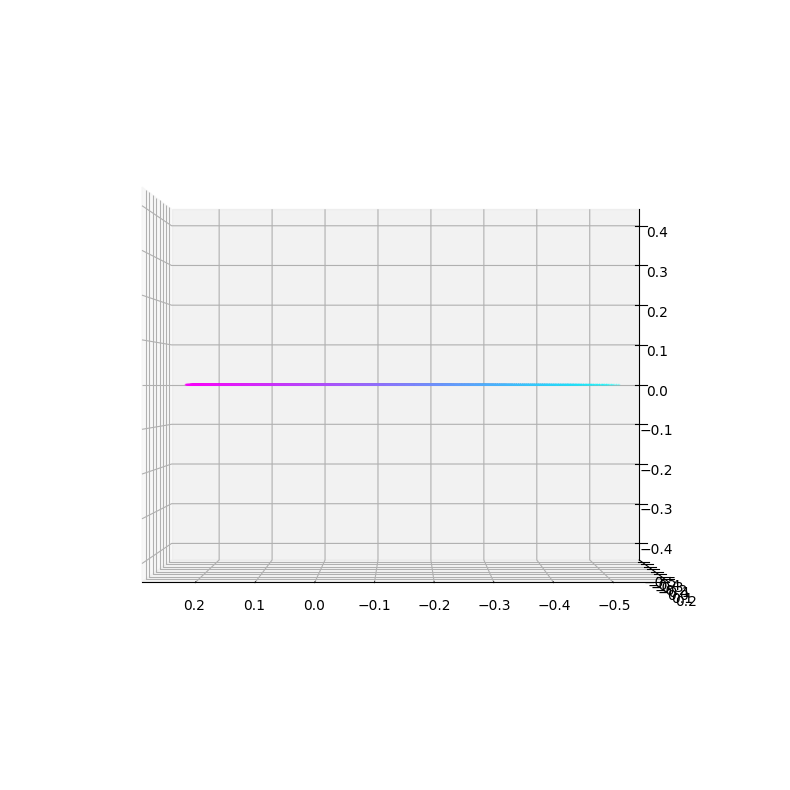

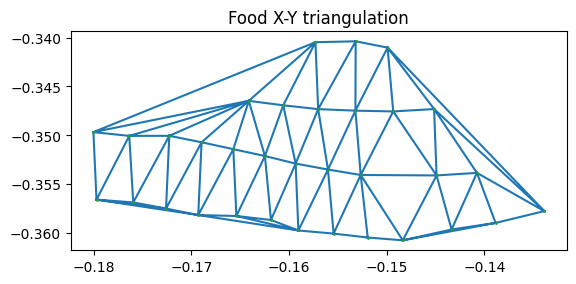

<Figure size 650x530 with 0 Axes>

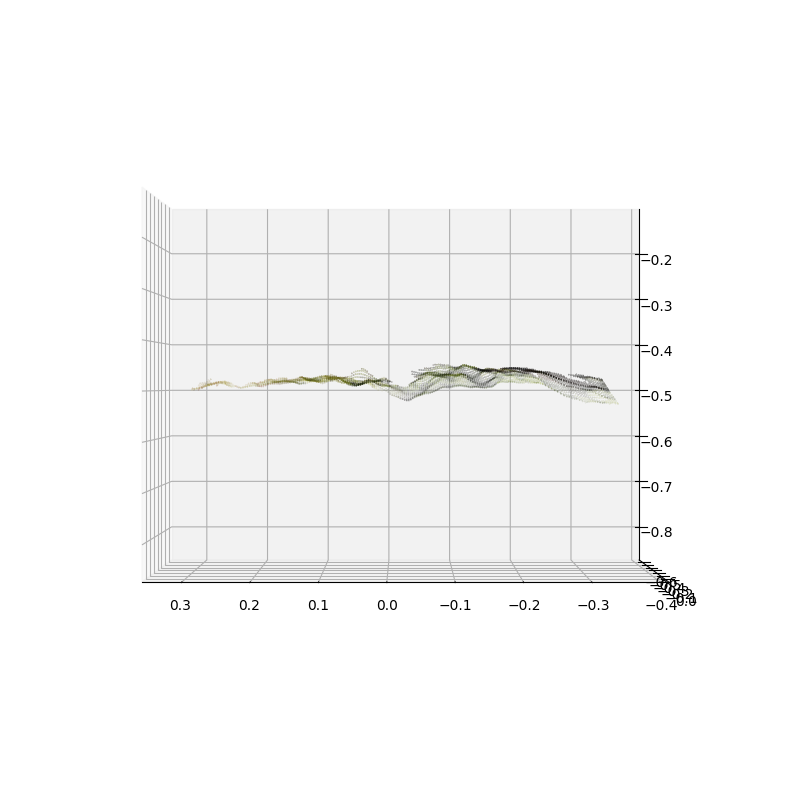

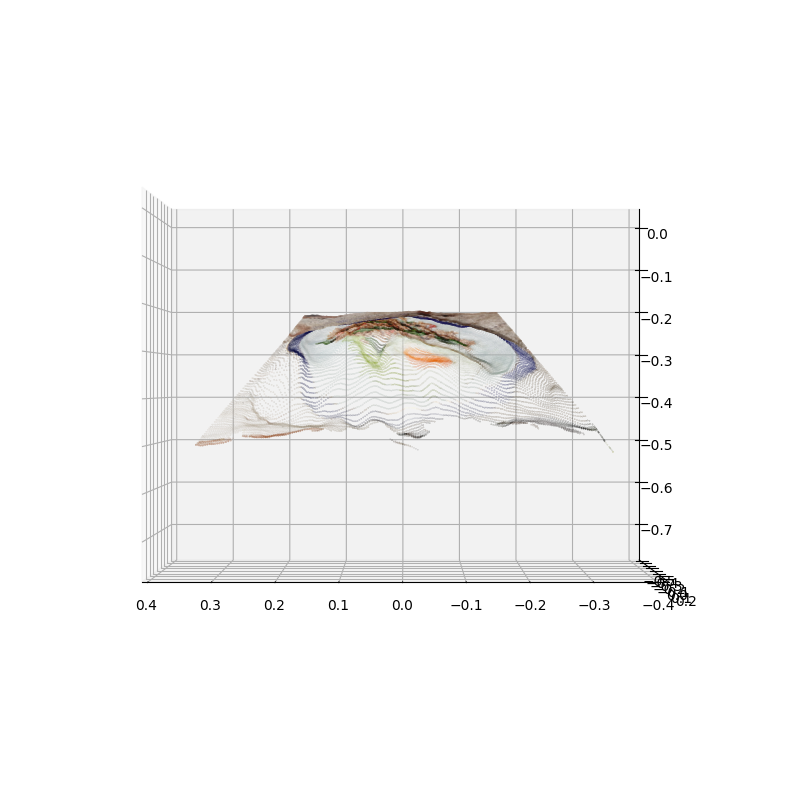

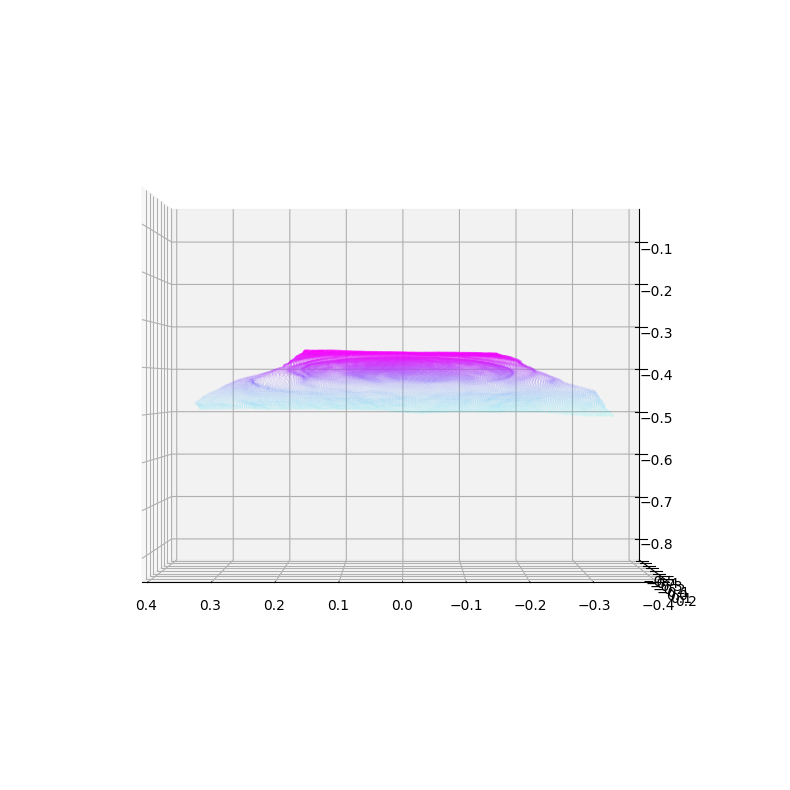

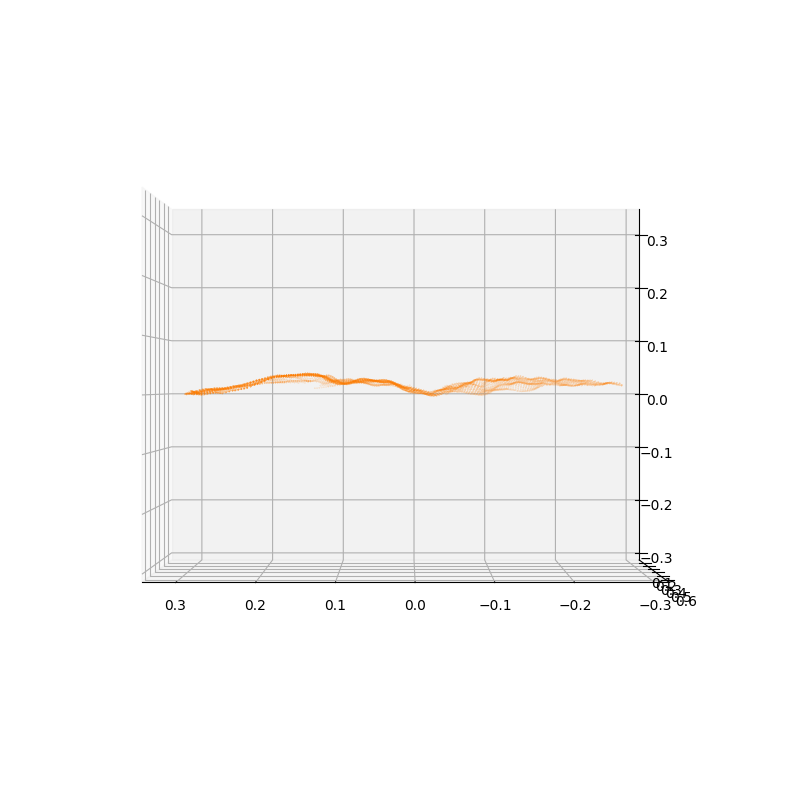

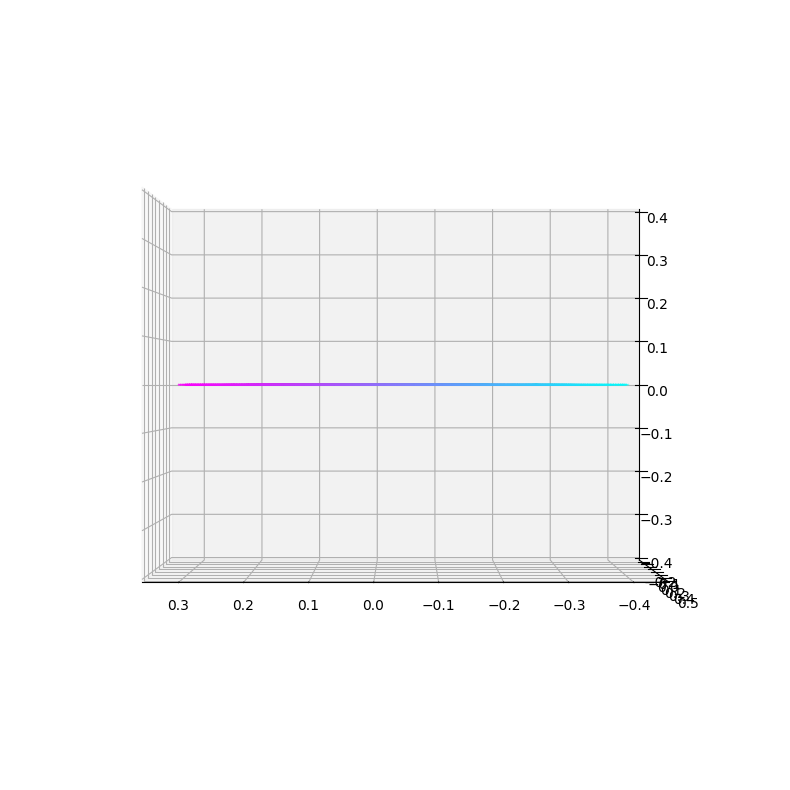

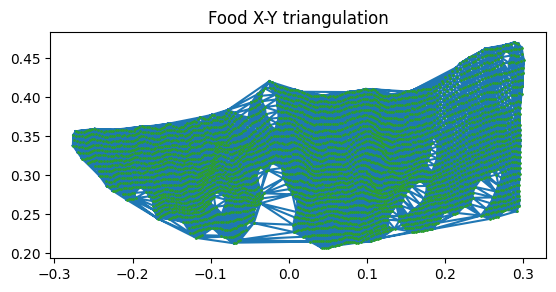

<Figure size 650x530 with 0 Axes>

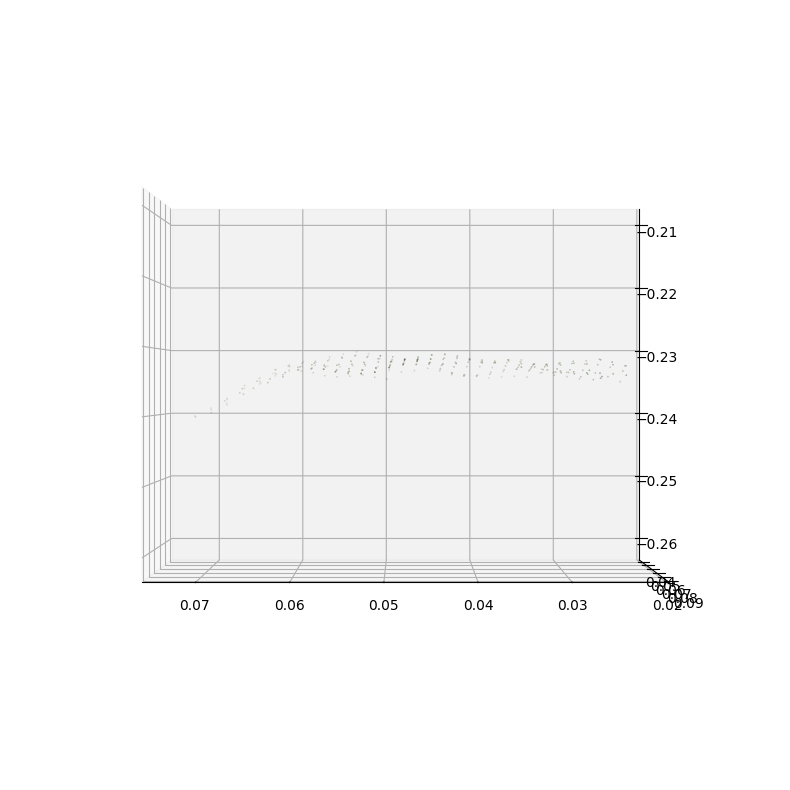

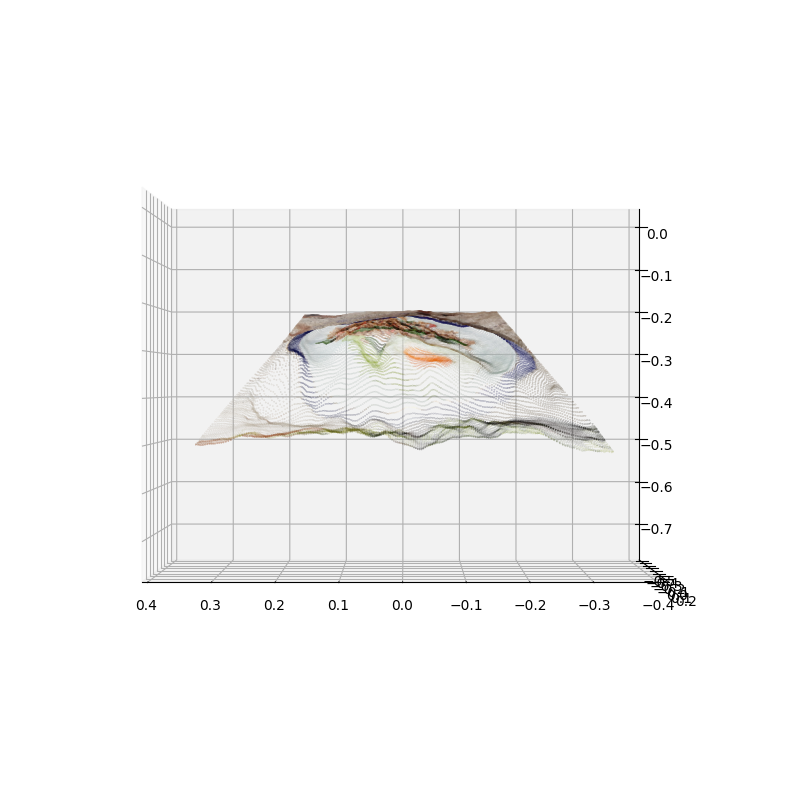

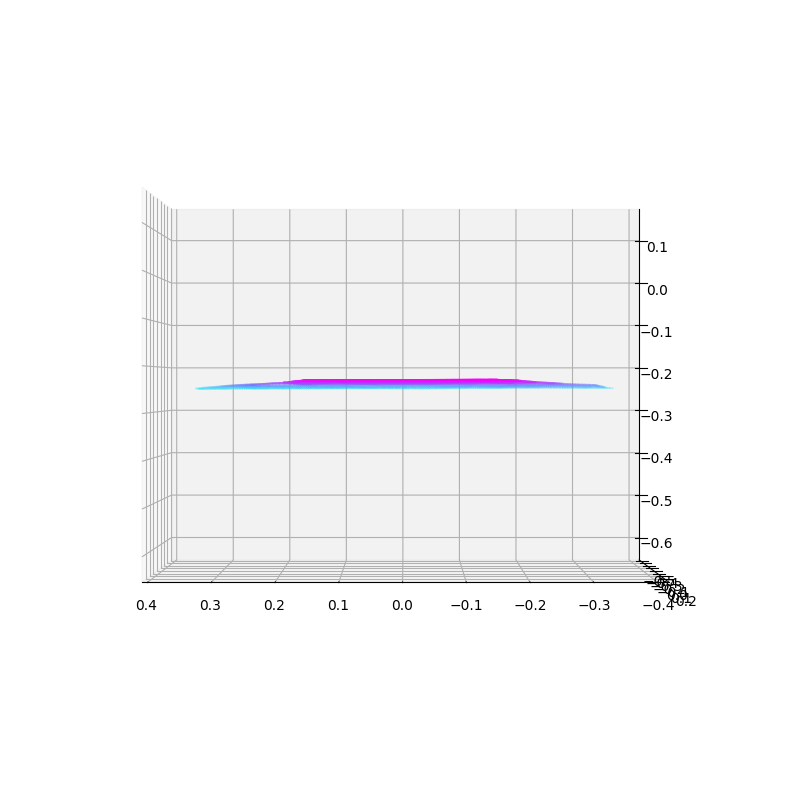

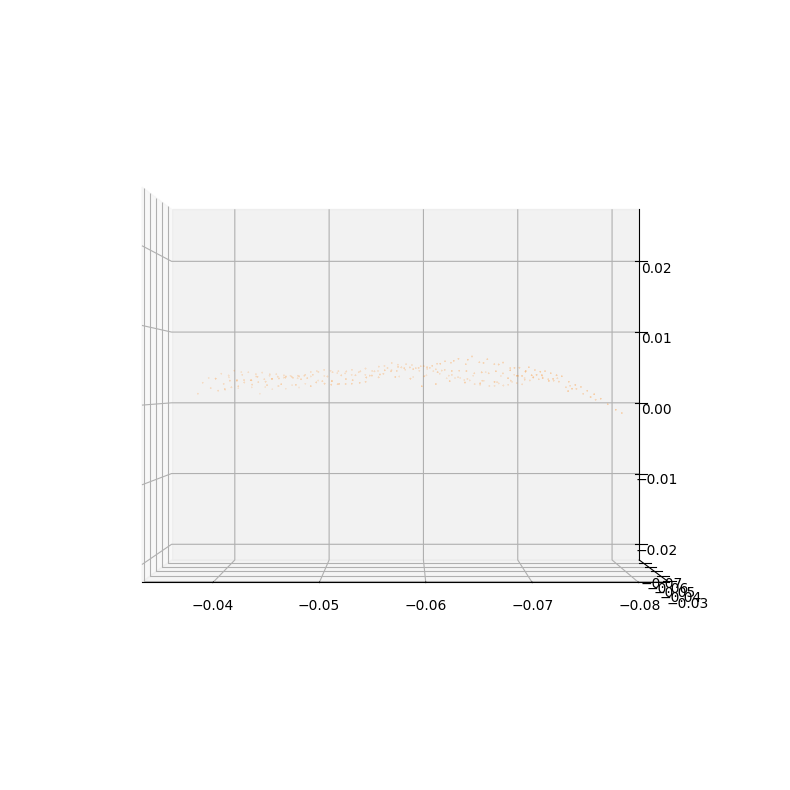

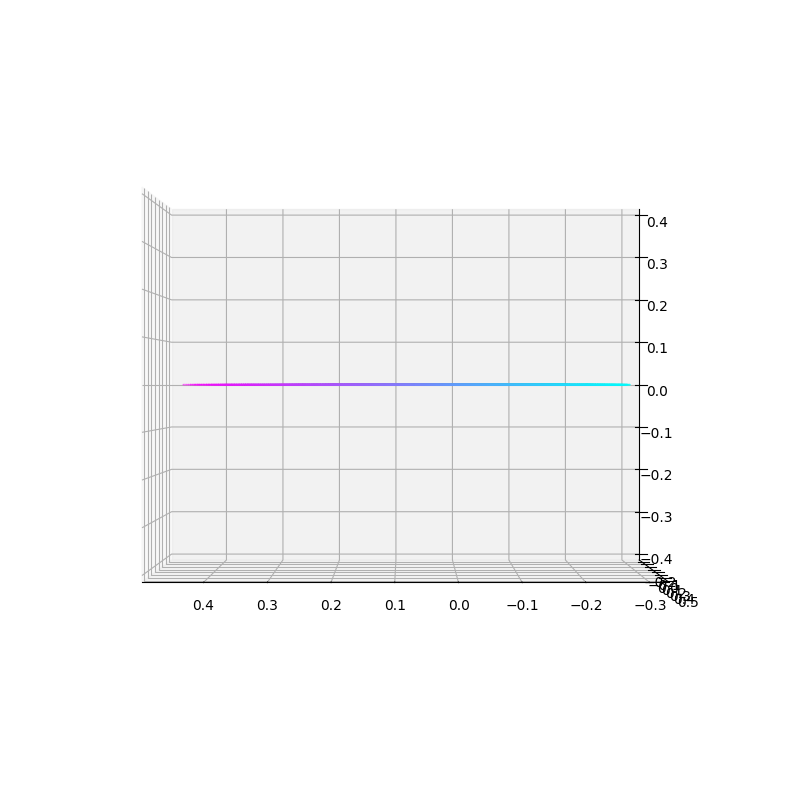

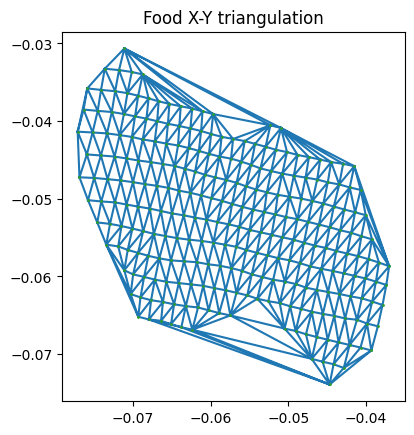

<Figure size 650x530 with 0 Axes>

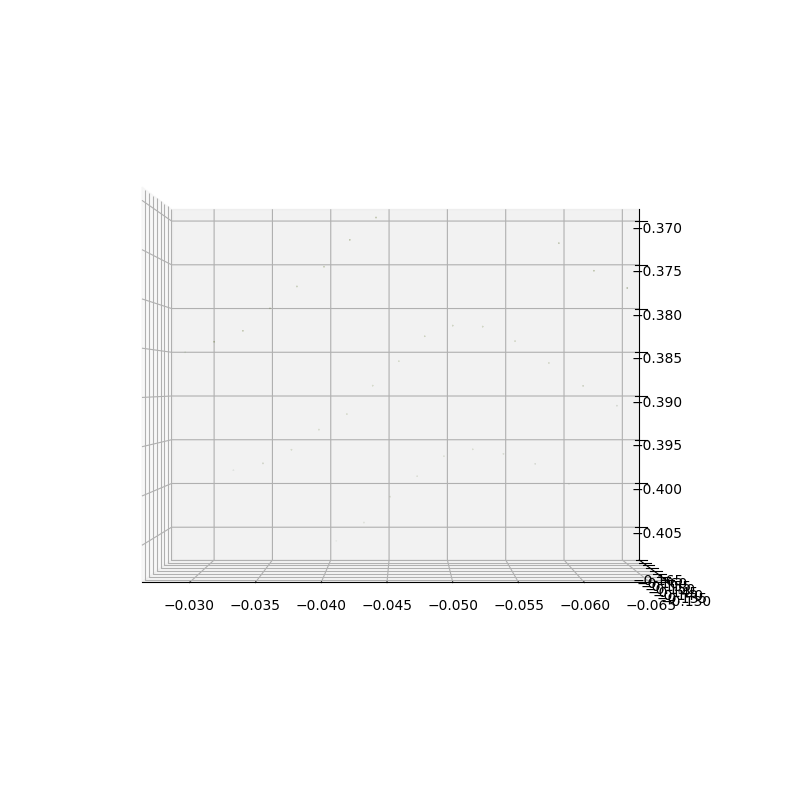

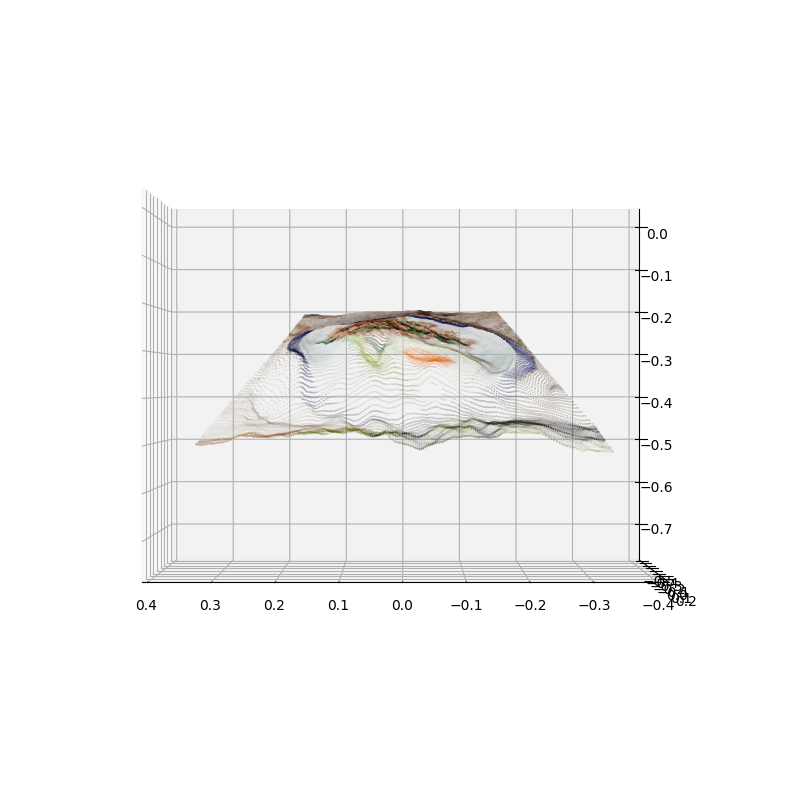

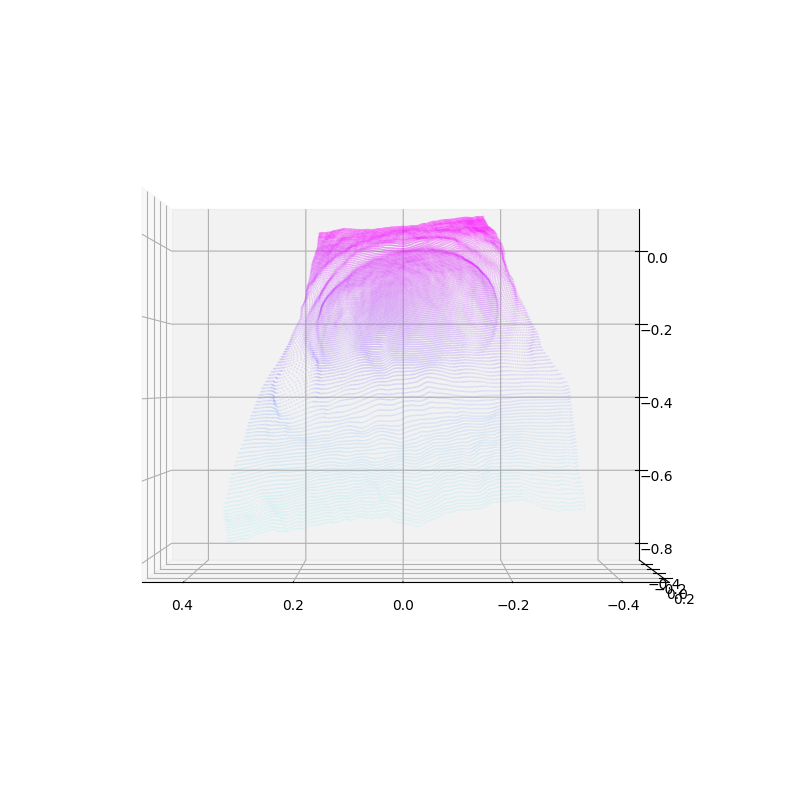

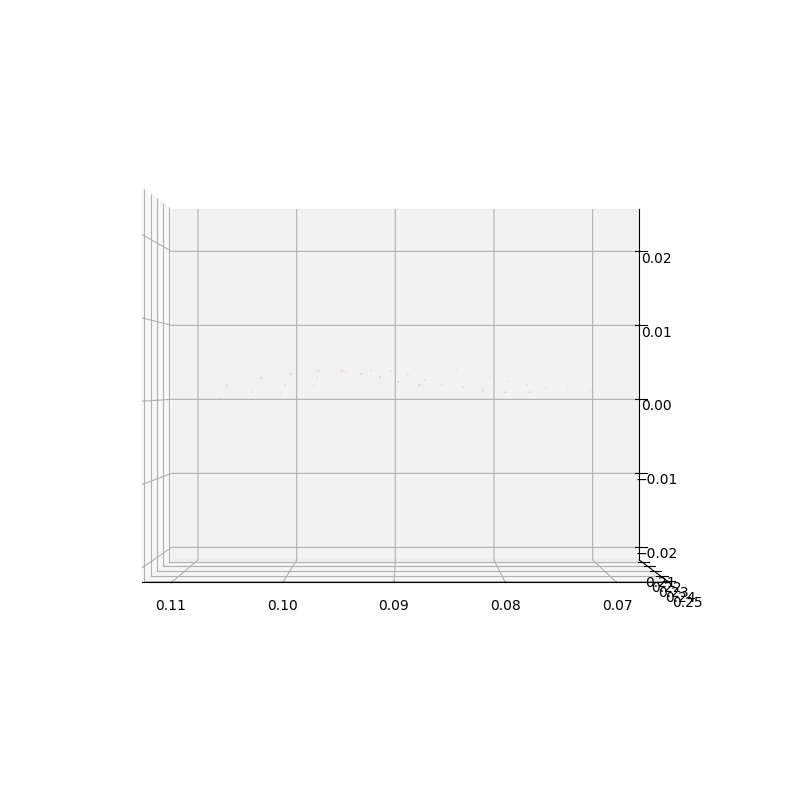

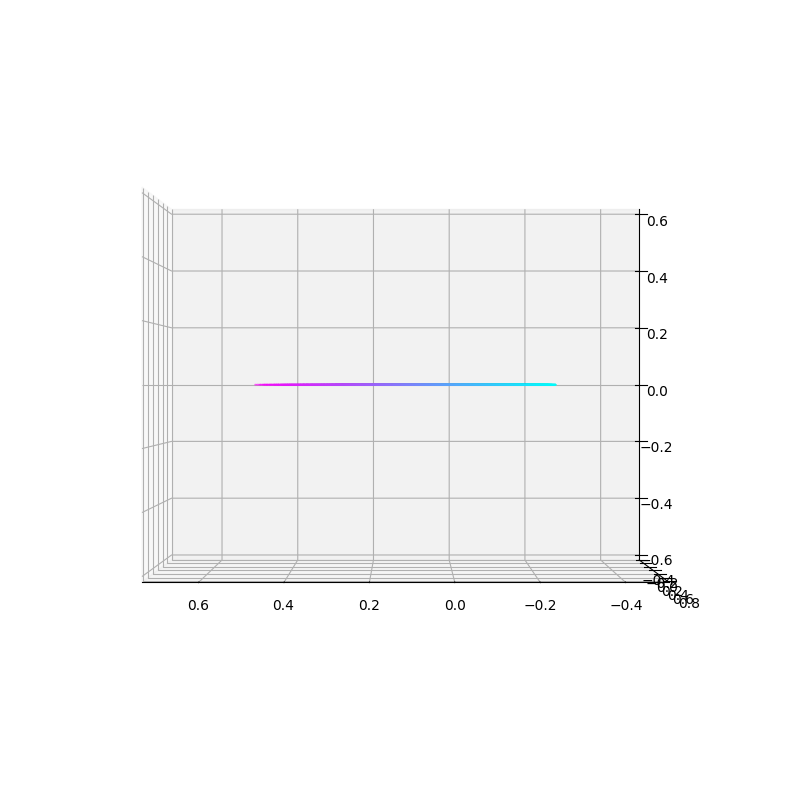

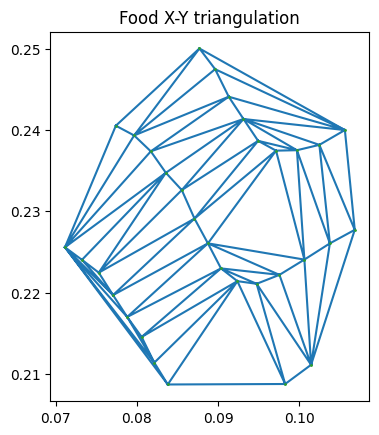

In [9]:
%matplotlib inline
# Estimate volumes in input image
input_image = '/Users/thanayot/Downloads/final_expo/images/Test image/ข้าวกระเพรา.jpg'
plate_diameter = 0.35 # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)

# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, 
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.set_size_inches(6.5, 5.3)
    
    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:,0] *= -1
    object_points_df.values[:,2] *= -1
    non_object_points_df.values[:,0] *= -1
    non_object_points_df.values[:,2] *= -1
    plane_points_df.values[:,0] *= -1
    plane_points_df.values[:,2] *= -1
    
    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001, use_as_color='z', cmap='cool', scene=scene)
    
    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:,2] > 0]
    plt.figure()
    plt.triplot(volume_points[:,0], volume_points[:,1], simplices)
    plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()